In [32]:
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import describe
import datetime
from datetime import timedelta as timedelta
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import signal
import os, sys
sys.path.append( '/home/ugrads/c/clearloveyanzhen/CufflessBP/bioz_processing' )
import sicong_util as su
import sicong_duck_path as sp
import sicong_duck_path as sdp
plt.rcParams.update({'font.size': 13})
import seaborn as sns
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import random
import math
import mat73

### Selecting trials with clean alignments

In [2]:
bp_align=pd.read_csv('../bioz_processing/CTRAL_BioZ_BP_Realign.csv')
clean_list=bp_align[bp_align['phase_aligned_val']<=1]['filename'].tolist()

In [3]:
bp_align[bp_align['session']=='session06'].head(10)

,pname,session,trial,test,filename,phase_aligned_val,final_val,comment
38,75A,session06,10_37_49,test00,/home/data/datasets/sicong_bioz_bp/75-1_75A/se...,0.000,996,default comment about test00
39,75A,session06,10_37_49,test01,/home/data/datasets/sicong_bioz_bp/75-1_75A/se...,1.067,996,default comment about test01
40,75A,session06,10_49_54,test00,/home/data/datasets/sicong_bioz_bp/75-1_75A/se...,1.172,996,default comment about test00
41,75A,session06,10_49_54,test01,/home/data/datasets/sicong_bioz_bp/75-1_75A/se...,0.750,996,default comment about test01
42,75A,session06,11_07_35,test00,/home/data/datasets/sicong_bioz_bp/75-1_75A/se...,0.949,996,default comment about test00
43,75A,session06,11_07_35,test01,/home/data/datasets/sicong_bioz_bp/75-1_75A/se...,1.651,996,default comment about test01
44,75A,session06,11_16_22,test00,/home/data/datasets/sicong_bioz_bp/75-1_75A/se...,0.955,996,default comment about test00
45,75A,session06,11_16_22,test01,/home/data/datasets/sicong_bioz_bp/75-1_75A/se...,1.978,996,default comment about test01
78,75C,session06,10_17_32,test00,/home/data/datasets/sicong_bioz_bp/75-2_75C/se...,233.000,996,Phase Align ERROR test00
79,75C,session06,10_17_32,test01,/home/data/datasets/sicong_bioz_bp/75-2_75C/se...,233.000,996,Phase Align ERROR test01


### Try MIMIC Correlation

<AxesSubplot:title={'center':'Distribution of "log_delta_ptt" among "sbp_stage"'}, xlabel='log_delta_ptt', ylabel='Count'>

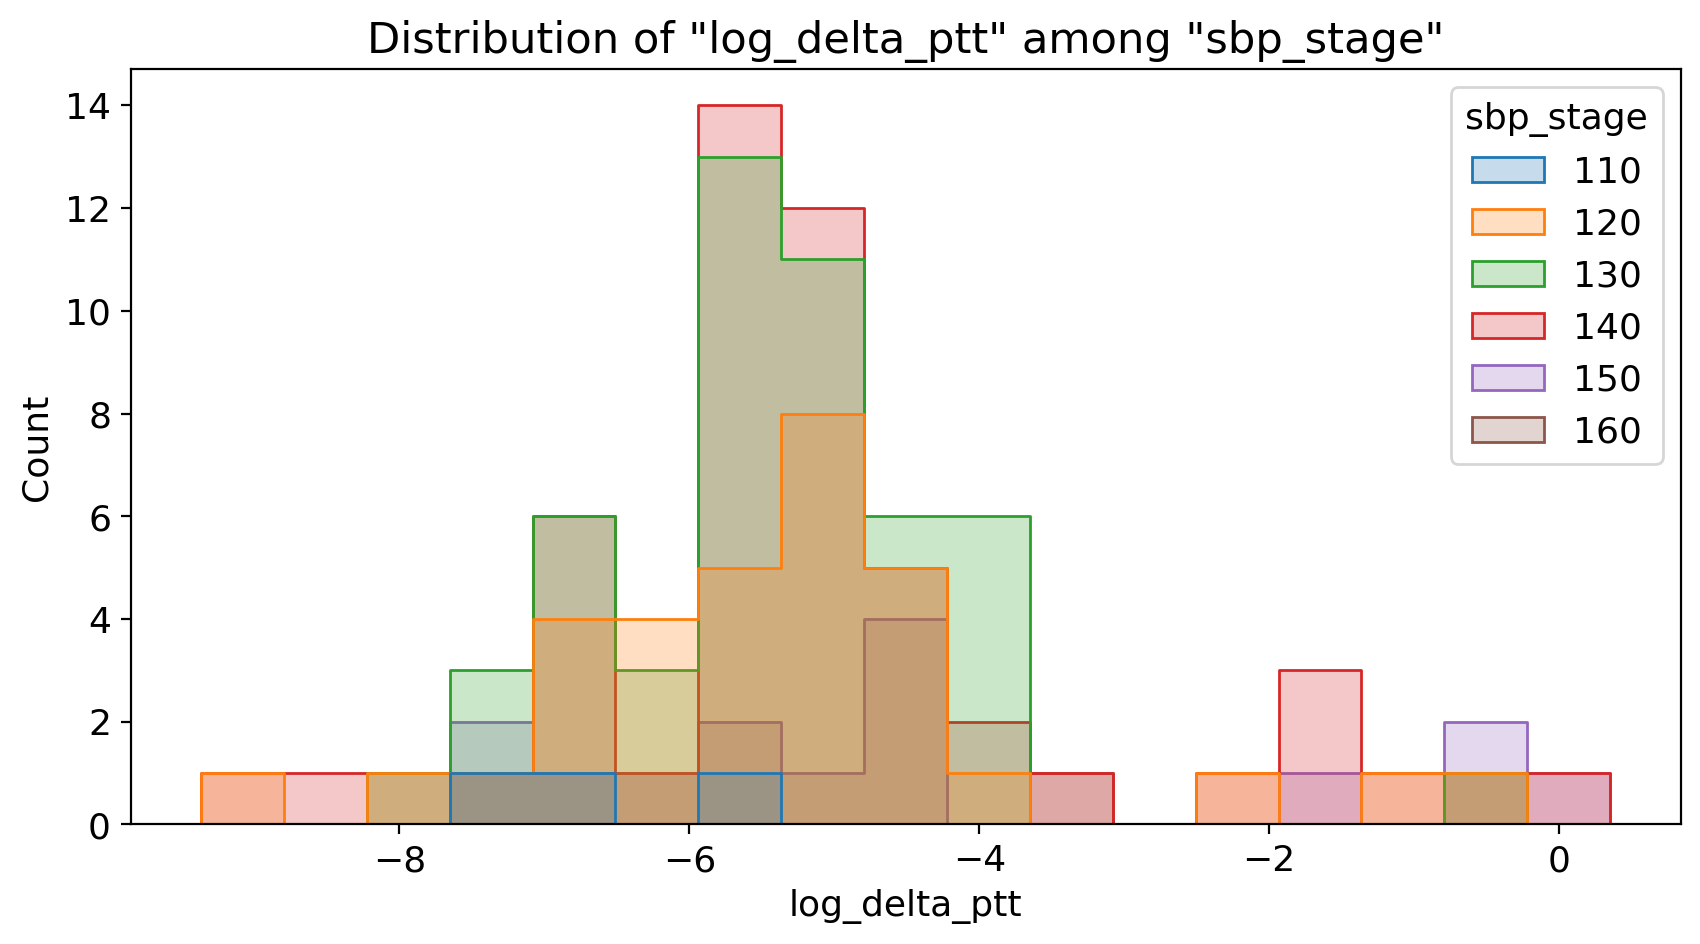

In [24]:
x='log_delta_ptt'
hue='sbp_stage'
plt.figure(figsize=(10, 5), dpi=200)
plt.title(f'Distribution of "{x}" among "{hue}"')
sns.histplot(data=all_df, x=x, hue=hue, element='step')

In [75]:
ml_df['t_dv'].head(7)

0    [1.849503005010057, 1.6923313698671099, 1.8541...
1    [2.5789680823609076, 2.5016279061085647, 2.583...
2    [3.335108187741769, 3.284411730470118, 3.34017...
3    [4.097917073307517, 4.060550797271277, 4.10301...
4    [4.863393472936506, 4.834029302940828, 4.86850...
5    [5.630203629725889, 5.606176789283891, 5.63531...
6    [6.397775933240138, 6.377563421871572, 6.40289...
Name: t_dv, dtype: object

In [127]:
wave_df=pd.read_csv('/home/Data-Zhaleh/p042694-2111-04-08-15-20/waveforms.csv')
bp_df=pd.read_csv('/home/Data-Zhaleh/p042694-2111-04-08-15-20/bp.csv')

In [129]:
wave_df.dropna(inplace=True)
bp_df.dropna(inplace=True)

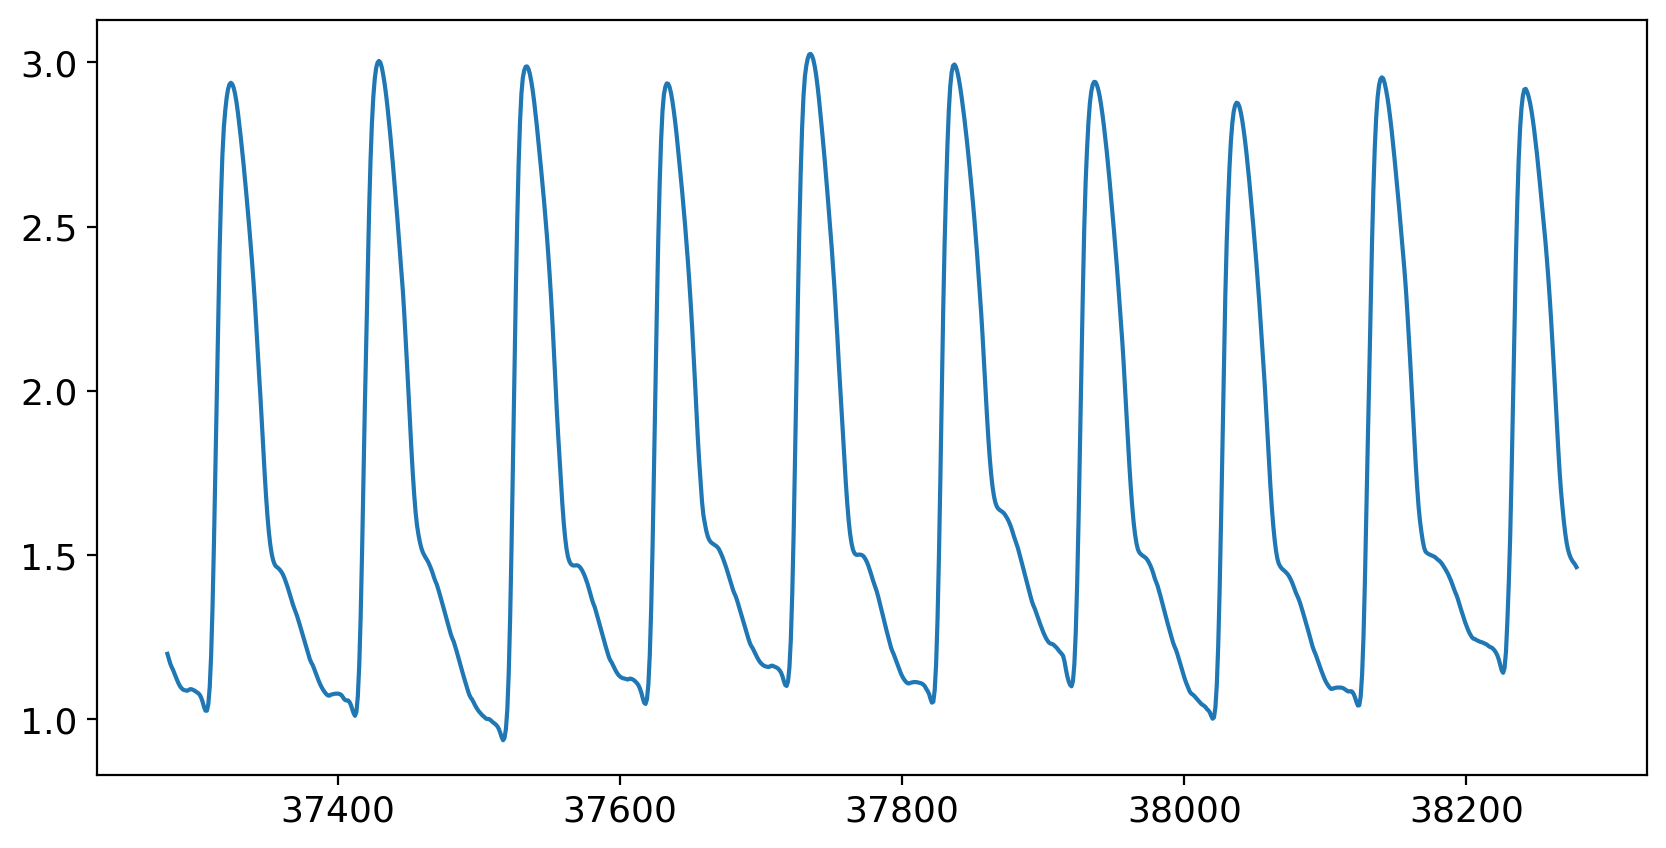

In [136]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(wave_df['PPG'][:1000])

In [138]:
import numpy as np
import neurokit2 as nk
def get_SBP_DBP(waveform):
  
    SBP_data = []
    DBP_data = []
    beat_2_beat_wf = []
    _, rpeaks = nk.ecg_peaks(waveform['ECG'].values, sampling_rate=125)
    rpeaks = rpeaks['ECG_R_Peaks']
    
    
    
    for i in range(len(rpeaks)-1):
        
        SBP_data.append(np.amax(waveform[rpeaks[i]:rpeaks[i+1]]['ABP'].values))
        DBP_data.append(np.amin(waveform[rpeaks[i]:rpeaks[i+1]]['ABP'].values))
        
        beat_2_beat_wf.append(np.array(waveform[rpeaks[i]:rpeaks[i+1]][['PPG','ECG']].values))
        
    beat_2_beat_wf = np.asarray(beat_2_beat_wf)
    
    return SBP_data, DBP_data, beat_2_beat_wf
def create_zero_padded_beats(waveform):
    
    max_len = 0
    padded_x = []
    beat_2_beat_wf = []
    SBP_data = []
    DBP_data = []
    max_len_save = []
    _, rpeaks = nk.ecg_peaks(waveform['ECG'].values, sampling_rate=125)
    rpeaks = rpeaks['ECG_R_Peaks']
    
    
    for i in range(len(rpeaks)-1):
        
        if (rpeaks[i+1] - rpeaks[i] > 250):
            continue
            
        if waveform[rpeaks[i]:rpeaks[i+1]][['PPG','ECG','ABP']].isna().sum().sum() > 0:
            continue
        
        if rpeaks[i+1] - rpeaks[i] > max_len:
            max_len = rpeaks[i+1] - rpeaks[i]
           
        SBP_data.append(np.amax(waveform[rpeaks[i]:rpeaks[i+1]]['ABP'].values))
        DBP_data.append(np.amin(waveform[rpeaks[i]:rpeaks[i+1]]['ABP'].values))
        beat_2_beat_wf.append(np.array(waveform[rpeaks[i]:rpeaks[i+1]][['PPG','ECG']].values))    
        
        
    print('max_len', max_len)
    
    for beat in beat_2_beat_wf: 
        
        tmp_zeros = np.zeros((max_len-len(beat),2))
        pad_x = np.concatenate((tmp_zeros, beat),axis=0)
        padded_x.append(pad_x) 
    
    return SBP_data, DBP_data, rpeaks, max_len, padded_x

In [184]:
_, rpeaks = nk.ecg_peaks(wave_df['ECG'].values, sampling_rate=125)
ppg_pks, _ = signal.find_peaks(wave_df['PPG'])
sbp, _, _ = get_SBP_DBP(wave_df)
rpeaks=rpeaks['ECG_R_Peaks']
ppg_pks+=37279
rpeaks+=37279

/tmp/ipykernel_613559/2274128555.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  beat_2_beat_wf = np.asarray(beat_2_beat_wf)


In [185]:
wave_df['ECG'][rpeaks[:100]]

37355    0.820137
37460    0.835288
37560    0.930108
37661    0.855327
37763    0.935484
           ...   
47037    0.965298
47140    0.900293
47244    0.820137
47351    0.840176
47457    0.815249
Name: ECG, Length: 100, dtype: float64

In [186]:
ptt = (rpeaks[:100] - ppg_pks[:100])/125

In [187]:
rpeaks[:10], ppg_pks[:10]

(array([37355, 37460, 37560, 37661, 37763, 37862, 37963, 38066, 38169,
        38271]),
 array([37295, 37324, 37399, 37429, 37534, 37569, 37607, 37633, 37707,
        37735]))

In [ ]:
plt.figure(figsize=(10, 5), dpi=200)
sns.histplot(data=mdf, element='step', )

### Testing Functions

In [16]:
morph_dict = su.export_morph_feat_to_dict()[0]
finapres_dict = su.export_finapres_to_dict()[0]
ml = morph_dict['A']['01']['11_29_43'][0]
ml_df=pd.read_csv(ml)
fprs = finapres_dict['A']['01']['11_29_43'][0]
fprs_obj=pd.read_csv(fprs)
ml_df.head()

,ptt_mst,ch1_ms_ibi,ch1_dia_to_ms_td,ch1_dia_to_sys_td,ch1_dia_to_ip_td,ch1_dia_to_ms_ad,ch1_dia_to_sys_ad,ch1_dia_to_ip_ad,ch2_ms_ibi,ch2_dia_to_ms_td,...,ch1_dia_to_sys_integrate,ch1_dia_to_ip_integrate,ch1_dia_to_dia2_integrate,ch2_dia_to_ms_integrate,ch2_dia_to_sys_integrate,ch2_dia_to_ip_integrate,ch2_dia_to_dia2_integrate,t_dv,ch1_dz,ch2_dz
0,0.002816,0.839381,0.767019,0.841259,1.060480,0.012867,-0.001074,0.014476,0.839040,0.768000,...,0.005573,0.005057,0.005573,0.004068,0.003598,0.003164,0.003598,"[1.849503005010057, 1.6923313698671099, 1.8541...","[0.013423993659684514, 0.013651660617322583, 0...","[0.009485401784481042, 0.00962146616123007, 0...."
1,0.000469,0.836437,0.762197,0.830848,1.060437,0.014671,0.003786,0.017292,0.834091,0.759509,...,0.003352,0.003986,0.003352,0.002611,0.002242,0.002564,0.002242,"[2.5789680823609076, 2.5016279061085647, 2.583...","[0.002631092684060427, 0.0029993296663729015, ...","[0.0009279739243081174, 0.0011792020709159618,..."
2,0.003840,0.868992,0.800341,0.872192,1.108224,0.010100,-0.002739,0.014919,0.872363,0.800555,...,0.003769,0.003962,0.003769,0.003565,0.003112,0.003257,0.003112,"[3.335108187741769, 3.284411730470118, 3.34017...","[-0.0024192181453841547, -0.002696608024978009...","[-6.941779689320208e-05, -0.000248262533923060..."
3,-0.002560,0.889515,0.817664,0.891989,1.123328,0.012963,-0.000119,0.015098,0.883115,0.811776,...,0.005423,0.005156,0.005423,0.004151,0.003676,0.003523,0.003676,"[4.097917073307517, 4.060550797271277, 4.10301...","[0.008624023049049636, 0.00874595579272028, 0....","[0.006569011225397522, 0.006644177277022123, 0..."
4,-0.000213,0.872619,0.798293,0.869760,1.099179,0.013050,0.000366,0.016280,0.874965,0.798891,...,0.003956,0.003872,0.003956,0.003578,0.003125,0.003042,0.003125,"[4.863393472936506, 4.834029302940828, 4.86850...","[-0.010117325553692342, -0.009768404253786995,...","[-0.007454085501716066, -0.00719581604578194, ..."


In [24]:
e_df = pd.DataFrame()
# all_df['sbp_stage']=pd.cut(all_df['reSYS'], bins=np.arange(110, 171, 10), include_lowest=False, labels=np.arange(110, 161, 10))
# all_df['delta_sbp']= np.concatenate(([0], all_df['reSYS'][1:].to_numpy()-all_df['reSYS'][:-1].to_numpy()))
# e_df['delta_ptt']= np.concatenate(([0], ml_df['ptt_mst'][1:].to_numpy()-ml_df['ptt_mst'][:-1].to_numpy()))
# all_df['log_delta_ptt']= np.log(all_df['delta_ptt'])
# all_df['log_ptt_mst']= np.log(all_df['ptt_mst'])
# all_df['pp'] = all_df['reSYS']-all_df['reDIA']
# all_df['delta_sbp_stage']=pd.cut(all_df['delta_sbp'], bins=np.arange(-10, 11, 10), include_lowest=False, labels=['dec', 'inc'])
# all_df['pp_stage']=pd.cut(all_df['pp'], bins=np.arange(45, 66, 5), include_lowest=False, labels=np.arange(45, 65, 5))
# all_df['mst_stage']=pd.cut(all_df['ptt_mst'], bins=np.arange(-0.75, 1.25, 0.25), include_lowest=False, labels=np.arange(-0.75, 1.25, 0.25))
for col in ml_df.columns[-3:]:
    print(col)
    # e_df[f'delta_{col}']= np.concatenate(([0], ml_df[col][1:].to_numpy()-ml_df[col][:-1].to_numpy()))

t_dv
ch1_dz
ch2_dz


## Functions for BioZ Data Extract

In [25]:
def get_ibi_feats(ml_df):
    e_df = pd.DataFrame()
    for col in ml_df.columns[:-3]:
        e_df[f'delta_{col}']= np.concatenate(([0], ml_df[col][1:].to_numpy()-ml_df[col][:-1].to_numpy()))
    for col in ml_df.columns[-3:]:
        e_df[col]=ml_df[col][1:]
    return e_df
get_ibi_feats(ml_df).head()

,delta_ptt_mst,delta_ch1_ms_ibi,delta_ch1_dia_to_ms_td,delta_ch1_dia_to_sys_td,delta_ch1_dia_to_ip_td,delta_ch1_dia_to_ms_ad,delta_ch1_dia_to_sys_ad,delta_ch1_dia_to_ip_ad,delta_ch2_ms_ibi,delta_ch2_dia_to_ms_td,...,delta_ch1_dia_to_sys_integrate,delta_ch1_dia_to_ip_integrate,delta_ch1_dia_to_dia2_integrate,delta_ch2_dia_to_ms_integrate,delta_ch2_dia_to_sys_integrate,delta_ch2_dia_to_ip_integrate,delta_ch2_dia_to_dia2_integrate,t_dv,ch1_dz,ch2_dz
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,-0.002347,-0.002944,-0.004821,-0.010411,-0.000043,0.001804,0.004860,0.002816,-0.004949,-0.008491,...,-0.002220,-0.001071,-0.002220,-0.001457,-0.001356,-0.000601,-0.001356,"[2.5789680823609076, 2.5016279061085647, 2.583...","[0.002631092684060427, 0.0029993296663729015, ...","[0.0009279739243081174, 0.0011792020709159618,..."
2,0.003371,0.032555,0.038144,0.041344,0.047787,-0.004571,-0.006525,-0.002373,0.038272,0.041045,...,0.000417,-0.000024,0.000417,0.000954,0.000871,0.000693,0.000871,"[3.335108187741769, 3.284411730470118, 3.34017...","[-0.0024192181453841547, -0.002696608024978009...","[-6.941779689320208e-05, -0.000248262533923060..."
3,-0.006400,0.020523,0.017323,0.019797,0.015104,0.002863,0.002620,0.000179,0.010752,0.011221,...,0.001654,0.001194,0.001654,0.000586,0.000563,0.000266,0.000563,"[4.097917073307517, 4.060550797271277, 4.10301...","[0.008624023049049636, 0.00874595579272028, 0....","[0.006569011225397522, 0.006644177277022123, 0..."
4,0.002347,-0.016896,-0.019371,-0.022229,-0.024149,0.000087,0.000485,0.001183,-0.008149,-0.012885,...,-0.001466,-0.001284,-0.001466,-0.000573,-0.000550,-0.000481,-0.000550,"[4.863393472936506, 4.834029302940828, 4.86850...","[-0.010117325553692342, -0.009768404253786995,...","[-0.007454085501716066, -0.00719581604578194, ..."


In [77]:
# additional features: changes in ptt, ibi, td
def make_batch(ml_df, fprs_obj, num_prev_beats=2, out_x=[], out_y=[]):
    fprs_sys = fprs_obj['reSYS'].to_numpy()
    fprs_dia = fprs_obj['reDIA'].to_numpy()
    fprs_time = fprs_obj['time (synced to ppg)'].to_numpy()
    for i, e in ml_df[num_prev_beats+1:-1:num_prev_beats+1].iterrows():
        feat_list=ml_df.loc[i][:-3].tolist()
        for j in range(i-num_prev_beats, i):
            feat_list = ml_df.loc[j][:-3].tolist()+feat_list
        bioz_ms_t = float(e['t_dv'][1:e['t_dv'].find(',')])
        fprs_idx = np.where(fprs_time == fprs_time[(fprs_time<=bioz_ms_t)][-1])[0][0]
        out_x.append(feat_list)
        out_y.append([fprs_sys[fprs_idx], fprs_dia[fprs_idx]])
    return out_x, out_y
out_x=[]; out_y=[]
out_x, out_y = make_batch(ml_df, fprs_obj, num_prev_beats=9, out_x=out_x, out_y=out_y)
# out_x, out_y = make_batch(ml_df, fprs_obj, out_x=out_x, out_y=out_y)
np.array(out_x).shape, np.array(out_y).shape

((26, 230), (26, 2))

## Extracting BioZ Data

In [97]:
selected_trials=['10_37_49', '10_49_54', '11_07_35', '11_16_22']
for selected_trial in selected_trials:
    for pname in su.subject_list[0]:
        out_x=[]
        out_y=[]
        for session in finapres_dict[pname]:
            if session!='0000':
                print(f'Processing Subject {pname}; Session {session}')
                for trial in finapres_dict[pname][session]:
                    for i, file in enumerate(finapres_dict[pname][session][trial]):
                        # if morph_dict[pname][session][trial][i][:-10]+'.mat' in clean_list:
                        if selected_trial in morph_dict[pname][session][trial][i][:-10]+'.mat':
                            print(morph_dict[pname][session][trial][i])
                            ml_df=pd.read_csv(morph_dict[pname][session][trial][i])
                            # ml_df=get_ibi_feats(ml_df) # Replaces original feats with IBI feats
                            fprs_obj=pd.read_csv(finapres_dict[pname][session][trial][i])
                            out_x, out_y = make_batch(ml_df, fprs_obj, num_prev_beats=2, out_x=out_x, out_y=out_y)
    # su.email_func(subject=f'Finished Morph Extraction', message=f'Finished Subject {pname}')
        np.save(f'batched_data/X_file 75{pname} Morph s6 {selected_trial}', np.array(out_x))
        np.save(f'batched_data/y_file 75{pname} Morph s6 {selected_trial}', np.array(out_y))
# su.email_func(subject=f'Morph Extraction ALL Done')
'done'

Processing Subject A; Session 01
Processing Subject A; Session 02
Processing Subject A; Session 03
Processing Subject A; Session 04
Processing Subject A; Session 05
Processing Subject A; Session 06
/home/data/datasets/sicong_bioz_bp/75-1_75A/session06_0402_2021/test00-20210402 10_37_49.morph_csv
/home/data/datasets/sicong_bioz_bp/75-1_75A/session06_0402_2021/test01-20210402 10_37_49.morph_csv
Processing Subject A; Session 07
Processing Subject A; Session 01
Processing Subject A; Session 02
Processing Subject A; Session 03
Processing Subject A; Session 04
Processing Subject A; Session 05
Processing Subject A; Session 06
/home/data/datasets/sicong_bioz_bp/75-1_75A/session06_0402_2021/test00-20210402 10_49_54.morph_csv
/home/data/datasets/sicong_bioz_bp/75-1_75A/session06_0402_2021/test01-20210402 10_49_54.morph_csv
Processing Subject A; Session 07
Processing Subject A; Session 01
Processing Subject A; Session 02
Processing Subject A; Session 03
Processing Subject A; Session 04
Processing

'done'

In [57]:
finapres_dict['H']['06']

{'13_20_26': ['/home/data/datasets/sicong_bioz_bp/75-5_75H/session06_05212021/finapres/test00-20210521 13_20_26.csv',
  '/home/data/datasets/sicong_bioz_bp/75-5_75H/session06_05212021/finapres/test01-20210521 13_20_26.csv'],
 '13_29_26': ['/home/data/datasets/sicong_bioz_bp/75-5_75H/session06_05212021/finapres/test00-20210521 13_29_26.csv',
  '/home/data/datasets/sicong_bioz_bp/75-5_75H/session06_05212021/finapres/test01-20210521 13_29_26.csv'],
 '13_46_18': ['/home/data/datasets/sicong_bioz_bp/75-5_75H/session06_05212021/finapres/test00-20210521 13_46_18.csv',
  '/home/data/datasets/sicong_bioz_bp/75-5_75H/session06_05212021/finapres/test01-20210521 13_46_18.csv'],
 '13_55_53': ['/home/data/datasets/sicong_bioz_bp/75-5_75H/session06_05212021/finapres/test00-20210521 13_55_53.csv',
  '/home/data/datasets/sicong_bioz_bp/75-5_75H/session06_05212021/finapres/test01-20210521 13_55_53.csv']}

In [43]:
clean_list[:][:-4]

['/home/data/datasets/sicong_bioz_bp/75-1_75A/session01_0225-2021/test00-20210225 11_29_43.mat',
 '/home/data/datasets/sicong_bioz_bp/75-1_75A/session01_0225-2021/test00-20210225 12_09_39.mat',
 '/home/data/datasets/sicong_bioz_bp/75-1_75A/session01_0225-2021/test01-20210225 12_09_39.mat',
 '/home/data/datasets/sicong_bioz_bp/75-1_75A/session01_0225-2021/test00-20210225 12_25_01.mat',
 '/home/data/datasets/sicong_bioz_bp/75-1_75A/session01_0225-2021/test01-20210225 12_25_01.mat',
 '/home/data/datasets/sicong_bioz_bp/75-1_75A/session05_0330_2021/test01-20210330 12_06_55.mat',
 '/home/data/datasets/sicong_bioz_bp/75-1_75A/session05_0330_2021/test01-20210330 12_32_38.mat',
 '/home/data/datasets/sicong_bioz_bp/75-1_75A/session05_0330_2021/test01-20210330 12_41_46.mat',
 '/home/data/datasets/sicong_bioz_bp/75-1_75A/session06_0402_2021/test00-20210402 10_37_49.mat',
 '/home/data/datasets/sicong_bioz_bp/75-1_75A/session06_0402_2021/test01-20210402 10_49_54.mat',
 '/home/data/datasets/sicong_b